In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots 
from scipy.stats import chi2_contingency
from itertools import combinations
import prince

In [2]:
df = pd.read_csv('../data/credit_risk_dataset.csv')
df = df.dropna()
df = df.drop_duplicates()

In [3]:
df['loan_status'] = df['loan_status'].astype('object')

In [7]:
qual_cols = df.select_dtypes(include=['object']).columns.difference(['loan_status'])
qual_cols

Index(['cb_person_default_on_file', 'loan_grade', 'loan_intent',
       'person_home_ownership'],
      dtype='object')

In [11]:
colors = {0: '#1f77b4', 1: '#d62728'}  # blue = non-default, red = default

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=qual_cols)

for i, col in enumerate(qual_cols):
    row = math.floor(i / 2) + 1
    col_pos = (i % 2) + 1
    
    # Compute counts per category and loan_status
    counts = df.groupby([col, 'loan_status']).size().reset_index(name='count')
    pivot_df = counts.pivot(index=col, columns='loan_status', values='count').fillna(0)
    
    # Add stacked bars with fixed colors
    for status in pivot_df.columns:
        fig.add_trace(
            go.Bar(
                x=pivot_df.index,
                y=pivot_df[status],
                name=f"loan_status={status}",
                marker_color=colors[status],
                showlegend=(i == 0)  # show legend only once
            ),
            row=row, col=col_pos
        )

fig.update_layout(
    barmode='stack',
    height=1000,
    width=1200,
    title_text="Stacked Bar Charts of Qualitative Columns by Loan Status"
)

fig.show()

In [17]:
for col1, col2 in combinations(qual_cols, 2):
    table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, _ = chi2_contingency(table)
    if p < 0.05:
        print(f"{col1} and {col2} are related (p={p:.4f})")

cb_person_default_on_file and loan_grade are related (p=0.0000)
cb_person_default_on_file and person_home_ownership are related (p=0.0000)
loan_grade and loan_intent are related (p=0.0002)
loan_grade and person_home_ownership are related (p=0.0000)
loan_intent and person_home_ownership are related (p=0.0000)


In [16]:
for col in qual_cols:
    contingency_table = pd.crosstab(df[col], df['loan_status'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Test: {col} vs loan_status")
    print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}, dof = {dof}")
    print("-"*50)


Chi-Square Test: cb_person_default_on_file vs loan_status
Chi2 = 947.04, p-value = 0.0000, dof = 1
--------------------------------------------------
Chi-Square Test: loan_grade vs loan_status
Chi2 = 5109.53, p-value = 0.0000, dof = 6
--------------------------------------------------
Chi-Square Test: loan_intent vs loan_status
Chi2 = 464.65, p-value = 0.0000, dof = 5
--------------------------------------------------
Chi-Square Test: person_home_ownership vs loan_status
Chi2 = 1639.66, p-value = 0.0000, dof = 3
--------------------------------------------------


In [45]:
qual_cols = df.select_dtypes(include=['object']).columns.difference(['loan_status'])

ca_data_clean = df[qual_cols]

ca_data_encoded = pd.get_dummies(ca_data_clean, drop_first=False)

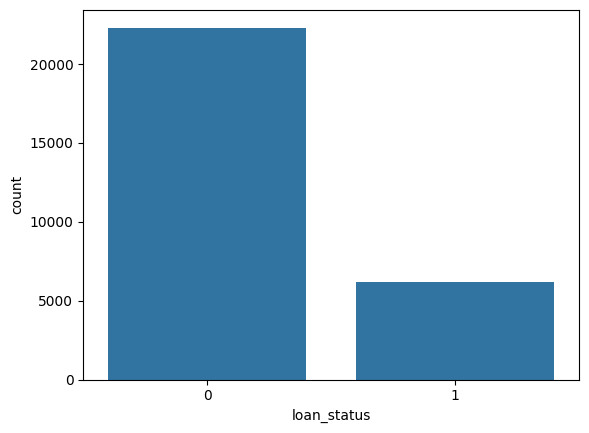

In [49]:
sns.countplot(data=df, x='loan_status')
plt.show()

In [47]:
ca = prince.CA(n_components=2, n_iter=10, copy=True, check_input=True, random_state=2)
ca = ca.fit(ca_data_encoded)

row_coords = ca.row_coordinates(ca_data_encoded)
col_coords = ca.column_coordinates(ca_data_encoded)

colors = df['loan_status'].map({0: 'blue', 1: 'red'})

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=row_coords[0],
    y=row_coords[1],
    mode='markers',
    marker=dict(color=colors, size=6),
    text=[f"Index: {i}, Status: {s}" for i, s in zip(df.index, df['loan_status'])],
    name='Borrowers'
    
))

for i, cat in enumerate(col_coords.index):
    fig.add_trace(go.Scatter(
        x=[0, col_coords.iloc[i, 0]],
        y=[0, col_coords.iloc[i, 1]],
        mode='lines+markers+text',
        marker=dict(color='black', size=4),
        line=dict(color='black', width=2),
        text=[None, cat],
        textposition='top right',
        name='Category'
    ))
    
# Layout
fig.update_layout(
    title='CA Symmetric Biplot',
    xaxis_title='CA Dimension 1',
    yaxis_title='CA Dimension 2',
    showlegend=False,
    width=1000,
    height=800
)

fig.show()